The following produces and evaluates a series of models for predicting housing prices in San Francisco, using sci-kit learn libraries. The data is based on: https://github.com/RuiChang123/Regression_for_house_price_estimation. 

Note that some of the grid search options are limited (eg Random Forest, AdaBoost) and some algorithms were not really pursued (Lasso and SVM) due to the time it took to finish training (if training even finished at all after letting it run overnight) or due to memory overflows (Random Forest). Because this notebook is for learning and demonstration purposes, we will just accept these limitations as they are here, as it is nice to have all the cells complete at a steady pace and finish in not much more than an hour or two.

Finally, due to limitations of SageMaker (where this was deleveloped) the XGBoost and Keras/Tensorflow results can be found in a different notebook in this git repository.

Now, onto the training and analysis. First, we import the necessary libraries and the data.

In [1]:
import boto3
import pandas as pd
import numpy as np
from sagemaker import get_execution_role

In [2]:
role = get_execution_role()
bucket='scott-upload'
data_key = 'housing_data_raw.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

In [3]:
housing = pd.read_csv(data_location)

We checkpoint our dataset, so we do not have to start over from scratch in case we want to alter it later, and create a DataFrame for querying.

In [5]:
base_housing = housing.copy()
df = pd.DataFrame(housing)

Let's take a look at how this data is distributed across the various fields

In [4]:
housing.describe()

,Unnamed: 0,bathrooms,bedrooms,finishedsqft,lastsoldprice,latitude,longitude,totalrooms,yearbuilt,zestimate,zipcode,zpid
count,11330.000000,11330.000000,11330.000000,11330.000000,1.133000e+04,11330.000000,11330.000000,11330.000000,11330.000000,1.133000e+04,11330.000000,1.133000e+04
mean,9171.729214,1.980229,2.614475,1585.420918,1.263928e+06,37.759711,-122.436518,6.111562,1948.498147,1.565695e+06,94116.912004,3.689973e+07
std,4921.941074,1.047358,1.299457,921.978245,1.042079e+06,0.025578,0.030743,12.125819,37.911196,1.229417e+06,9.400877,7.800741e+07
min,2.000000,0.500000,0.000000,1.000000,5.350000e+02,37.708170,-122.510726,1.000000,1860.000000,4.323850e+05,94102.000000,1.506329e+07
25%,5039.750000,1.000000,2.000000,1019.000000,7.292500e+05,37.739286,-122.455157,4.000000,1916.000000,9.052375e+05,94110.000000,1.510847e+07
50%,9198.500000,2.000000,2.000000,1362.000000,9.900000e+05,37.760513,-122.432510,5.000000,1940.000000,1.230758e+06,94115.000000,1.515697e+07
75%,13374.750000,2.000000,3.000000,1876.000000,1.450000e+06,37.781386,-122.413359,7.000000,1986.000000,1.731170e+06,94123.000000,5.970040e+07
max,17632.000000,14.000000,20.000000,27275.000000,2.388900e+07,37.806083,-122.381201,1264.000000,2016.000000,1.553325e+07,94158.000000,2.146999e+09


Let's review a couple of charts of the data, to see how different fields relate to the sold price

In [6]:
import matplotlib.pyplot as plt

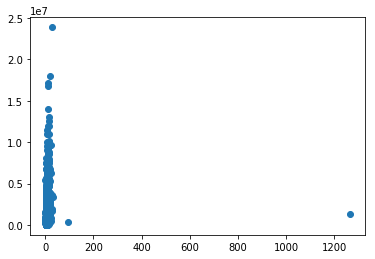

In [7]:
x = housing['totalrooms']
y = housing['lastsoldprice']
plt.scatter(x,y)
plt.show()

This is an unusual looking graph, which is drastically skewed due to a single outlier. Let's take a closer look at it.

In [8]:
housing['totalrooms'].sort_values()

7524        1.0
11223       1.0
3579        1.0
2132        1.0
5453        1.0
2827        1.0
7621        1.0
4452        1.0
8171        1.0
3211        1.0
9409        1.0
92          1.0
1976        1.0
10988       1.0
3179        1.0
7455        1.0
10433       1.0
243         1.0
5398        1.0
2321        1.0
10595       1.0
7179        1.0
2016        1.0
595         1.0
1304        1.0
4144        1.0
2567        1.0
6719        1.0
2757        1.0
2449        1.0
          ...  
5209       19.0
6162       19.0
10698      20.0
8782       20.0
8964       20.0
7381       20.0
927        20.0
7736       20.0
2796       20.0
9705       21.0
1978       21.0
7554       21.0
4693       22.0
929        23.0
1194       23.0
10287      23.0
11004      23.0
2765       23.0
8288       24.0
9201       24.0
6860       24.0
4802       26.0
8087       26.0
11083      27.0
2601       28.0
2750       28.0
10727      28.0
11175      33.0
8300       94.0
8967     1264.0
Name: totalrooms, Length

We can see above that there are 1264 total rooms in one house, which is unlikely. We can take an even closer look at it, as well at the one just above it (with 94 rooms).

In [9]:
df.iloc[[8967]]

,Unnamed: 0,address,info,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zindexvalue,zipcode,zpid
8967,14048,Address: 2829 California Street #3C,San FranciscoSales price: 1375000Sales date: ...,2829 California St APT 3C,2.0,2.0,1264.0,03/14/2013,1375000.0,37.787654,-122.440902,Lower Pacific Heights,1264.0,Condominium,2012.0,1591608.0,"1,146,900",94115.0,119684820.0


In [10]:
df.iloc[[8300]]

,Unnamed: 0,address,info,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zindexvalue,zipcode,zpid
8300,13101,Address: 5264 3rd Street #304,San FranciscoSales price: 325000Sales date: 0...,5264 3rd St APT 304,2.0,2.0,805.0,07/18/2013,325000.0,37.729825,-122.392825,Bayview,94.0,Condominium,1993.0,502285.0,"719,000",94124.0,15158931.0


In both cases, total rooms is almost definitely a mistake, probably a typo on data entry. So we will eliminate those data points. But first, let's look at the finished square feet.

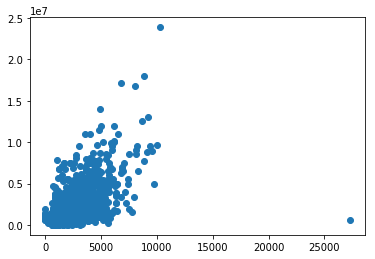

In [11]:
x = housing['finishedsqft']
y = housing['lastsoldprice']
plt.scatter(x,y)
plt.show()

In [12]:
housing['finishedsqft'].sort_values()

1618         1.0
3405         1.0
10652        1.0
954          1.0
11136        1.0
5103         1.0
916          1.0
10967        1.0
7383         1.0
1465         1.0
8134       243.0
7300       244.0
6485       250.0
7621       252.0
3199       264.0
10988      265.0
2499       291.0
9156       292.0
10553      292.0
1734       307.0
6588       329.0
4214       360.0
7455       362.0
6936       365.0
92         376.0
4451       383.0
3035       383.0
4437       383.0
1886       385.0
9628       390.0
          ...   
523       6800.0
2765      6807.0
10159     6835.0
2673      6850.0
9547      6968.0
1195      7000.0
6676      7147.0
6762      7260.0
4807      7360.0
625       7375.0
8353      7500.0
10727     7500.0
1920      7750.0
11175     7957.0
1885      8000.0
5408      8120.0
2294      8125.0
7137      8180.0
3225      8335.0
1611      8675.0
8231      8820.0
6766      8822.0
7818      9125.0
427       9190.0
4575      9378.0
5704      9540.0
9650      9699.0
8087     10000

Along with the others, we will remove those listed at the top of the sorted list because 1 square foot is clearly inaccurate. The data also claims that there is a house in Pacific Heights with 2 bedrooms, 2 bathrooms, and is 27,000 square feet! Again, this is most likely an outlier so we will remove it.

In [13]:
def drop_outliers(data):
    data = data.drop([1618])
    data = data.drop([3405])
    data = data.drop([10652])
    data = data.drop([954])
    data = data.drop([11136])
    data = data.drop([5103])
    data = data.drop([916])
    data = data.drop([10967])
    data = data.drop([7383])
    data = data.drop([1465])
    data = data.drop([8967])
    data = data.drop([8300])
    data = data.drop([4997])  
    return data
housing = drop_outliers(housing)
housing['finishedsqft'].sort_values()

8134       243.0
7300       244.0
6485       250.0
7621       252.0
3199       264.0
10988      265.0
2499       291.0
9156       292.0
10553      292.0
1734       307.0
6588       329.0
4214       360.0
7455       362.0
6936       365.0
92         376.0
3035       383.0
4451       383.0
4437       383.0
1886       385.0
6565       390.0
9628       390.0
10433      395.0
7023       396.0
11269      398.0
16         398.0
6698       400.0
7368       400.0
8465       409.0
7607       409.0
3179       410.0
          ...   
1617      6762.0
523       6800.0
2765      6807.0
10159     6835.0
2673      6850.0
9547      6968.0
1195      7000.0
6676      7147.0
6762      7260.0
4807      7360.0
625       7375.0
8353      7500.0
10727     7500.0
1920      7750.0
11175     7957.0
1885      8000.0
5408      8120.0
2294      8125.0
7137      8180.0
3225      8335.0
1611      8675.0
8231      8820.0
6766      8822.0
7818      9125.0
427       9190.0
4575      9378.0
5704      9540.0
9650      9699

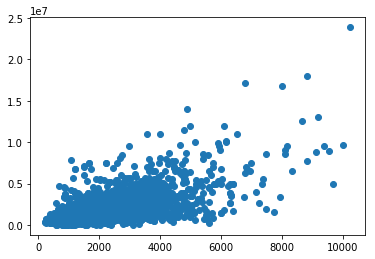

In [14]:
x = housing['finishedsqft']
y = housing['lastsoldprice']
plt.scatter(x,y)
plt.show()

That looks much better. Now let's modify the time values so that they are integers (UNIX time) instead of strings. This will allow regression algorithms to use them in training, for example, to determine that a house sold at one date will cost a different amount than the same or similar house sold on a different date.

In [15]:
housing['lastsolddateint'] = pd.to_datetime(housing['lastsolddate'], format='%m/%d/%Y').astype('int')
housing['lastsolddateint'] = housing['lastsolddateint']/1000000000
housing = housing[housing['lastsolddateint'].notnull()]
housing

,Unnamed: 0,address,info,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zindexvalue,zipcode,zpid,lastsolddateint
0,2,Address: 1160 Mission Street #2007,San FranciscoSales price: 1300000Sales date: ...,1160 Mission St UNIT 2007,2.0,2.0,1043.0,02/17/2016,1300000.0,37.778705,-122.412635,South of Market,4.0,Condominium,2007.0,1167508.0,"975,700",94103.0,83152781.0,1.455667e+09
1,5,Address: 260 King Street #475,San FranciscoSales price: 750000Sales date: 0...,260 King St UNIT 475,1.0,1.0,903.0,02/17/2016,750000.0,37.777641,-122.393417,South of Market,3.0,Condominium,2004.0,823719.0,"975,700",94107.0,69819817.0,1.455667e+09
2,7,Address: 560 Missouri Street #B,San FranciscoSales price: 1495000Sales date: ...,560 Missouri St # B,4.0,3.0,1425.0,02/17/2016,1495000.0,37.759198,-122.396516,Potrero Hill,6.0,Condominium,2003.0,1708594.0,"1,277,600",94107.0,64972847.0,1.455667e+09
3,9,Address: 350 Missouri Street,San FranciscoSales price: 2700000Sales date: ...,350 Missouri St,3.0,3.0,2231.0,02/17/2016,2700000.0,37.761886,-122.396769,Potrero Hill,10.0,SingleFamily,1927.0,2411236.0,"1,277,600",94107.0,15149489.0,1.455667e+09
4,11,Address: 3658 Folsom Street,San FranciscoSales price: 1530000Sales date: ...,3658 Folsom St,3.0,3.0,1300.0,02/17/2016,1530000.0,37.740795,-122.413453,Bernal Heights,4.0,SingleFamily,1900.0,1918539.0,"1,248,000",94110.0,15161978.0,1.455667e+09
5,12,Address: 156 Lowell Street,San FranciscoSales price: 460000Sales date: 0...,156 Lowell St,1.0,2.0,1250.0,02/17/2016,460000.0,37.710226,-122.446027,Crocker Amazon,5.0,SingleFamily,1924.0,703392.0,"823,000",94112.0,15178981.0,1.455667e+09
6,13,Address: 735 Lakeview Avenue,San FranciscoSales price: 532000Sales date: 0...,735 Lakeview Ave,1.0,3.0,1032.0,02/17/2016,532000.0,37.718024,-122.460332,Oceanview,6.0,SingleFamily,1939.0,741715.0,"762,700",94112.0,15192274.0,1.455667e+09
7,14,Address: 430 Capistrano Avenue,San FranciscoSales price: 1050000Sales date: ...,430 Capistrano Ave,1.0,2.0,1200.0,02/17/2016,1050000.0,37.725204,-122.439273,Mission Terrace,5.0,SingleFamily,1924.0,1023650.0,"992,600",94112.0,15141129.0,1.455667e+09
8,15,Address: 4135 23rd Street,San FranciscoSales price: 3500000Sales date: ...,4135 23rd St,3.5,4.0,2700.0,02/17/2016,3500000.0,37.752602,-122.435011,Noe Valley,9.0,SingleFamily,1912.0,3604950.0,"1,782,000",94114.0,15131647.0,1.455667e+09
9,16,Address: 440 Steiner Street,San FranciscoSales price: 1500000Sales date: ...,440 Steiner St,2.0,3.0,2016.0,02/17/2016,1500000.0,37.773237,-122.432302,Hayes Valley,7.0,Condominium,1890.0,1547314.0,"1,224,800",94117.0,118608077.0,1.455667e+09


In [16]:
clean_data = housing.copy()

That is much better, and we are getting close to a linear relationship. Let's see how we can model this. But first, we have to make lastsolddate a value that we can perform a mathematical calculation on, so we transform it into an int. We will also remove prices from around 2012, since some of these go back decades (but most are from the last few years).

Additionally, we will drop some fields that are unlikely to be useful for a linear model, including the geographic data. Obviously these are important, but it is not immediately clear how to map zipcode or address to a scalar value for our model. We also drop the zestimate and the zindexvalue, as these were calculated (by Zillow?) using their own model. We just want to look at the raw data and see what sort of model we can come up with.

In [17]:
def drop_geog(data, keep = []):
    remove_list = ['info','address','z_address','longitude','latitude','neighborhood','lastsolddate','zipcode','zpid','usecode', 'zestimate','zindexvalue']
    for k in keep:
        remove_list.remove(k)
    data = data.drop(remove_list, axis=1)
    data = data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1)
    return data

housing = drop_geog(housing)

Now that we have cleaned up some of the data, let's look at the correlations between the variables.

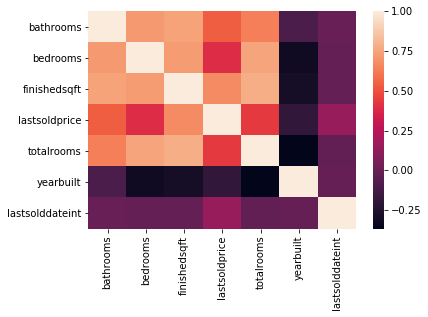

In [114]:
import seaborn as sns
sns.heatmap(housing.corr())

This shows us that there is a pretty high correlation between lastsoldprice and finishedsqft, which is not surprising. In fact, this is a much higher correlation than with bedrooms or totalrooms, although bathrooms fairs a bit better.
Now we will create a linear model and train it, using lastsoldprice as our target value.

In [18]:
from sklearn.model_selection import train_test_split

def split_data(data):
    y = data['lastsoldprice']
    X = data.drop('lastsoldprice', axis=1)
    # Return (X_train, X_test, y_train, y_test)
    return train_test_split(X, y, test_size=0.2, random_state=30)


In [19]:
import sys
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

from sklearn.linear_model import LinearRegression

def train_eval(algorithm, grid_params, X_train, X_test, y_train, y_test):
    regression_model = GridSearchCV(algorithm, grid_params, cv=5, n_jobs=-1, verbose=1)
    regression_model.fit(X_train, y_train)
    y_pred = regression_model.predict(X_test)
    print("R2: \t", r2_score(y_test, y_pred))
    print("RMSE: \t", sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE: \t", mean_absolute_error(y_test, y_pred))
    return regression_model
    
housing_split = split_data(housing)
train_eval(LinearRegression(), {}, *housing_split)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.5366066917131977
750678.476479495
433245.6519384096


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

This is not a terrible score (it shows a linear relationship) but it is really not a great score either. But we can checkpoint this model (by uncommenting and running the below code) in S3 in case we want to use it later.

In [20]:
# Note the Python version, since this model will not work in other Python versions
#sys.version_info[0]
#pyver = sys.version_info[0]

#from sklearn.externals import joblib
#filename = 'MyModel.sav'
#joblib.dump(regression_model, filename)
#s3 = boto3.resource('s3')
#s3.meta.client.upload_file(filename, 'my-s3-bucket', 'hp-model-' + str(pyver))

Next we look at other variations of linear regression, as well as other machine learning algorithms.

In [21]:
from sklearn.linear_model import Ridge

ridge_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
ridge = train_eval(Ridge(), ridge_params, *housing_split)
ridge.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.536566932696846
750710.6797905002
433215.8364058313


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


{'alpha': 10}

In [22]:
from sklearn.linear_model import Lasso

lasso_params = {'alpha': [0.1, 1, 10], 'max_iter': [10000, 25000]}
lasso = train_eval(Lasso(), lasso_params, *housing_split)
lasso.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.536604560098389
750680.2030425336
433243.79336846014


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.7s finished


{'alpha': 10, 'max_iter': 10000}

In [23]:
from sklearn.neighbors import KNeighborsRegressor
knn_params = {'n_neighbors' : [1, 5, 10, 20, 30, 50, 75, 100, 200, 500]}
model = train_eval(KNeighborsRegressor(), knn_params, *housing_split)
model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.15060023694456648
1016330.95341843
540260.1489399293


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.6s finished


{'n_neighbors': 5}

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

tree_params = {}
train_eval(DecisionTreeRegressor(), tree_params, *housing_split)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.09635601667334437
1048281.1237086286
479376.222614841


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [25]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

forest_params = {'n_estimators': [1000], 'max_depth': [None], 'min_samples_split': [2]}
forest = train_eval(RandomForestRegressor(), forest_params, *housing_split)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


0.6071295620858653
691200.04921061
367126.8614028794


In [26]:
from sklearn.ensemble import GradientBoostingRegressor

gbm_params = {'alpha' : [.1, .5, .9], 'learning_rate': [.01, .1, 1], 'max_depth':[2,3,5], 'n_estimators':[10, 100, 150]}
gbm = train_eval(GradientBoostingRegressor(), gbm_params, *housing_split)
gbm.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   57.8s finished


0.5592003071947464
732149.4264737129
388453.77059884043


{'alpha': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [27]:
from sklearn.ensemble import AdaBoostRegressor

ada_params = {'n_estimators': [10, 100, 250, 500], 'learning_rate': [.0001, .001, .01]}
adaboost = train_eval(AdaBoostRegressor(), ada_params, *housing_split)
adaboost.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   47.7s


0.4914904171169657
786373.1124272654
450287.8889303565


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.0min finished


{'learning_rate': 0.0001, 'n_estimators': 10}

Now let's trying some feature engineering to see if it makes a difference. First, we are going to re-retrieve our cleaned data, but this time with the neighborhood column. Including the neighborhood will allow our algorithms to consider whether the neighborhood plays a role in the price. Based on experience, most of us will know that a house in two different neighborhoods, which are otherwise equal, may have a substantially different price.

In [28]:
housing_cleaned = drop_geog(clean_data.copy(), ['neighborhood'])

Now, let's transform the neighborhood feature into a format that our algorithms can deal with. We can do this with One Hot Encoding. This transforms all of our string values into zeros and ones, and adds a new feature for each one of these values. For each of these neighborhood features, the value will be 1 if the data point in in that neighborhood and 0 otherwise.

In [29]:
one_hot = pd.get_dummies(housing_cleaned['neighborhood'])
housing_cleaned = housing_cleaned.drop('neighborhood',axis = 1)

For now, we simply hold onto the one-hot encoding, while also deleting the neighborhood feature. 

Now, we can center and scale our data so that they are all in a consistent format. This helps (and is even necessary, as we will see) some machine learning algorithms to make predictions on the data. Otherwise, fields that have a wider variation than others can play an oversized role in the prediction.

In [30]:
from sklearn.preprocessing import StandardScaler
(X_train, X_test, y_train, y_test) = split_data(housing_cleaned)
scaler = StandardScaler()
scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_train = X_train.join(one_hot)
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test = X_test.join(one_hot)

housing_split_cleaned = (X_train, X_test, y_train, y_test)

2041      575000.0
6589      803000.0
10491     835000.0
929      3500000.0
1484     2025000.0
8606      100000.0
10945     525000.0
388      1593000.0
4297     3750000.0
1728     1600000.0
4331      880000.0
2339      836000.0
9775      651000.0
5762     1300000.0
1605     1525000.0
3329      950000.0
1635     1070000.0
1843      660000.0
3519     2087500.0
8466      550000.0
3016      901000.0
9346      830000.0
7644     1011000.0
301       890000.0
9767     1200000.0
6719      405000.0
8975     1200000.0
1320      660000.0
8249     1900000.0
10374     450000.0
           ...    
870       788000.0
4017      720000.0
8748      850000.0
8420     1775000.0
9449     1460000.0
1459     1510000.0
4714      951000.0
7041     1275000.0
4697     1350000.0
8980     1850000.0
9534      925000.0
4289     1075000.0
5399      838700.0
7873      750000.0
10476    7350000.0
10243     789000.0
8987     1406500.0
9196     1600000.0
9755      550000.0
8302      630000.0
1098     2808000.0
4475      67

Now let's try training again, with the cleaned data.

In [46]:
empty_params = {}
model = train_eval(LinearRegression(), empty_params, *housing_split_cleaned)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.6328566983301503
668185.25771193
371451.9425795053


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


We can already see an improvement. Now let's take a look at the other algorithms.

In [32]:
model = train_eval(Ridge(), ridge_params, *housing_split_cleaned)
model.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.6326740229926028
668351.4677280113
371187.8693141953


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.0s finished


{'alpha': 1}

In [33]:
model = train_eval(KNeighborsRegressor(), knn_params, *housing_split_cleaned)
model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


0.6938710004544473
610142.5615480896
303699.6739399293


{'n_neighbors': 5}

This is substantially better! We KNN went from terrible, to better than linear regression.

In [34]:
model = train_eval(DecisionTreeRegressor(), tree_params,*housing_split_cleaned)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


0.39542277744197274
857442.439825675
383743.4403710247


In [35]:
model = train_eval(RandomForestRegressor(), forest_params, *housing_split_cleaned)
model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.0min finished


0.677028227379022
626702.4153226872
294772.5044353021


{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 1000}

In [36]:
model = train_eval(GradientBoostingRegressor(), gbm_params, *housing_split_cleaned)
model.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  55 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  4.6min finished


0.6583890868201707
644532.6957564729
294236.37829967606


{'alpha': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}

In [37]:
model = train_eval(AdaBoostRegressor(), ada_params, *housing_split_cleaned)
model.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.2min finished


0.4312890576967766
831619.9076784445
460993.4989463397


{'learning_rate': 0.0001, 'n_estimators': 10}

In general, these are getting quite a bit better, but we can still improve. We should reevaluate our goals here. Do we really want to predict the price of a house sold in San Francisco at an arbitrary point in time? No, probably not. What we really want is to predict the price of a house will be sold in the future. Unfortunately, this data set is already a few years old. But, what we could try is, given prices from before 2016 (the year this data was scraped), can we predict the price of a house sold in 2016? 

To try this, we will separate our pre-2016 data from our 2016 data. That is, 2016 data will be the test set, and pre-2016 data will be the training set.

In [39]:
len(clean_data[clean_data['lastsolddateint'] >= 1451690306.0])

11315

In [40]:
len(clean_data[clean_data['lastsolddateint'] < 1451690306.0])

2

In [52]:
housing_cleaned = drop_geog(clean_data.copy(), ['neighborhood'])
one_hot = pd.get_dummies(housing_cleaned['neighborhood'])
housing_cleaned = housing_cleaned.drop('neighborhood',axis = 1)

housing_cleaned_2016 = housing_cleaned[housing_cleaned['lastsolddateint'] >= 1451606400.0]
housing_cleaned_pre2016 = housing_cleaned[housing_cleaned['lastsolddateint'] < 1451606400.0]

X_train = housing_cleaned_pre2016.drop('lastsoldprice',axis = 1)
y_train = housing_cleaned_pre2016['lastsoldprice']
X_test = housing_cleaned_2016.drop('lastsoldprice',axis = 1)
y_test = housing_cleaned_2016['lastsoldprice']

scaler = StandardScaler()
scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_train = X_train.join(one_hot)
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test = X_test.join(one_hot)

housing_2016 = (X_train, X_test, y_train, y_test)

In [55]:
model = train_eval(LinearRegression(), empty_params, *housing_2016)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.5655143235078578
705595.9419018636
368231.789010989


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


In [56]:
model = train_eval(Ridge(), ridge_params, *housing_2016)
model.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.5654736636888247
705628.9564909427
367912.0225069891


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished


{'alpha': 1}

In [57]:
model = train_eval(KNeighborsRegressor(), knn_params, *housing_2016)
model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished


0.5917745802036787
683940.5678481678
339921.69362637366


{'n_neighbors': 5}

In [58]:
model = train_eval(DecisionTreeRegressor(), tree_params,*housing_2016)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


-0.2625813180762244
1202812.7469473258
561070.6901098901


In [59]:
model = train_eval(RandomForestRegressor(), forest_params, *housing_2016)
model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished


0.6449382763512762
637852.513123179
342572.9925384616


{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 1000}

In [60]:
model = train_eval(GradientBoostingRegressor(), gbm_params, *housing_2016)
model.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  54 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 204 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  5.4min finished


0.630165041911716
650987.0096284344
304833.2705639046


{'alpha': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}

In [61]:
model = train_eval(AdaBoostRegressor(), ada_params, *housing_2016)
model.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.9min finished


0.385870828230404
838876.8432951688
455762.6847942452


{'learning_rate': 0.001, 'n_estimators': 250}

Now, we should go even a step further. We do not want to go back to the beginning of all housing prices to determine the price of a house in the present. Specifically, there was a crash in the housing market around 2008-2011. So we want to start at least at 2012 to train our data and maybe later. That is, we do not want to force our algorithms to deal with this dip, we just want to see how prices have increased since then. The good news is, there is enough data to do this, all we are really doing is getting rid of some early, possibly outlier data.

In [62]:
housing_cleaned = drop_geog(clean_data.copy(), ['neighborhood'])
one_hot = pd.get_dummies(housing_cleaned['neighborhood'])
housing_cleaned = housing_cleaned.drop('neighborhood',axis = 1)

housing_cleaned_2016 = housing_cleaned[housing_cleaned['lastsolddateint'] >= 1451606400.0]
housing_cleaned_pre2016 = housing_cleaned[housing_cleaned['lastsolddateint'] < 1451606400.0]
housing_cleaned_2012_2015 = housing_cleaned_pre2016[housing_cleaned_pre2016['lastsolddateint'] >= 1325376000.0]

X_train = housing_cleaned_2012_2015.drop('lastsoldprice',axis = 1)
y_train = housing_cleaned_2012_2015['lastsoldprice']
X_test = housing_cleaned_2016.drop('lastsoldprice',axis = 1)
y_test = housing_cleaned_2016['lastsoldprice']

scaler = StandardScaler()
scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_train = X_train.join(one_hot)
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test = X_test.join(one_hot)

housing_2012_2016 = (X_train, X_test, y_train, y_test)

In [63]:
model = train_eval(LinearRegression(), empty_params, *housing_2012_2016)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.5480960392253182
719600.4335882488
398405.3978021978


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


In [64]:
model = train_eval(Ridge(), ridge_params, *housing_2012_2016)
model.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.548059814954011
719629.2743168602
398330.48391291883


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished


{'alpha': 1}

In [65]:
model = train_eval(KNeighborsRegressor(), knn_params, *housing_2012_2016)
model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.9min finished


0.5465621124747452
720820.6920389826
357043.06241758243


{'n_neighbors': 5}

In [66]:
model = train_eval(DecisionTreeRegressor(), tree_params,*housing_2012_2016)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
-0.2735148435107386
1208009.4956323102
554855.7538461538


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


In [67]:
model = train_eval(RandomForestRegressor(), forest_params, *housing_2012_2016)
model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.5min finished


0.6466906685441473
636276.5190388259
340716.62283736264


{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 1000}

In [68]:
model = train_eval(GradientBoostingRegressor(), gbm_params, *housing_2012_2016)
model.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 19.1min finished


0.6004631052455613
676623.0483369554
317996.38851451856


{'alpha': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}

In [69]:
model = train_eval(AdaBoostRegressor(), ada_params, *housing_2012_2016)
model.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.8min finished


0.37341820178850116
847339.0662304545
453082.24740908336


{'learning_rate': 0.001, 'n_estimators': 500}

Now let's see what happens when we train only on 2015 data and test only against 2016 data. I would expect, at the very least, for the change to be more linear and less of a curve, and for linear regression to perform better than the previous result, although I would still expect our winning strategies (Random Forest, Gradient Boost) to continue to win.

In [73]:
housing_cleaned = drop_geog(clean_data.copy(), ['neighborhood'])
one_hot = pd.get_dummies(housing_cleaned['neighborhood'])
housing_cleaned = housing_cleaned.drop('neighborhood',axis = 1)

housing_cleaned_2016 = housing_cleaned[housing_cleaned['lastsolddateint'] >= 1451606400.0]
housing_cleaned_pre2016 = housing_cleaned[housing_cleaned['lastsolddateint'] < 1451606400.0]
housing_cleaned_2015 = housing_cleaned_pre2016[housing_cleaned_pre2016['lastsolddateint'] >= 1420070400.0]

X_train = housing_cleaned_2015.drop('lastsoldprice',axis = 1)
y_train = housing_cleaned_2015['lastsoldprice']
X_test = housing_cleaned_2016.drop('lastsoldprice',axis = 1)
y_test = housing_cleaned_2016['lastsoldprice']

scaler = StandardScaler()
scaler.fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train[X_train.columns])
X_train = X_train.join(one_hot)
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
X_test = X_test.join(one_hot)

housing_2015_2016 = (X_train, X_test, y_train, y_test)

In [75]:
model = train_eval(LinearRegression(), empty_params, *housing_2015_2016)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.5220775448780501
740026.1399612884
422246.98021978023


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


In [76]:
model = train_eval(Ridge(), ridge_params, *housing_2015_2016)
model.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.5235830311951659
738859.6557632246
419615.33090262173


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


{'alpha': 1}

In [77]:
model = train_eval(KNeighborsRegressor(), knn_params, *housing_2015_2016)
model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.2s


0.4290044613127838
808881.1223387168
405034.22901098896


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   21.2s finished


{'n_neighbors': 5}

In [78]:
model = train_eval(DecisionTreeRegressor(), tree_params,*housing_2015_2016)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.22862390322116832
940159.2664584508
569296.4835164836


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [79]:
model = train_eval(RandomForestRegressor(), forest_params, *housing_2015_2016)
model.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.7min finished


0.5968528631404892
679673.1790971672
358246.2596


{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 1000}

In [80]:
model = train_eval(GradientBoostingRegressor(), gbm_params, *housing_2015_2016)
model.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 254 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  4.9min finished


0.6232034804031745
657085.3488877735
327380.90366608376


{'alpha': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}

In [81]:
model = train_eval(AdaBoostRegressor(), ada_params, *housing_2015_2016)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.1min finished


0.3896101663915059
836319.0477449143
479988.37946960767


We can see from this that it is easier to predict what happened in the past than what will happen in the future (with this data and approach, anyway). Also, some algorithms provide substantially better after feature engineering and scaling than before. Finally, the overall takeaway here is that Random Forest and Gradient Boosted Machines tend to perform best, although K-Nearest Neighbors also performed suprisingly well--in some circumstances.

Check out the other notebooks in this repo to see how other algorithms performed.